In [1]:
import pandas as pd
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape


(50000, 2)

In [2]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

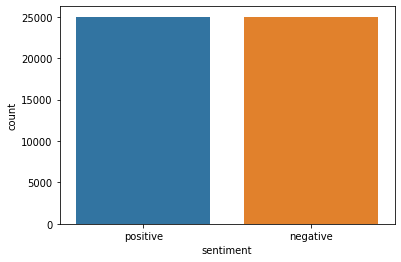

In [4]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

STOPWORDS.add('br')
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
   
    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    
    return text

In [8]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(text_prepare(sen))

In [9]:
X[3]

'basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parents divorcing arguing like real life jake closet totally ruins film expected see boogeyman similar movie instead watched drama meaningless thriller spots 3 10 well playing parents descent dialogs shots jake ignore'

In [10]:
import numpy as np

Y=movie_reviews['sentiment']
Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [11]:
Y[3]


0

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#print(X_train[6])

In [13]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X_train:
    for word in text.split():
        words_counts[word] += 1

In [14]:
DICT_SIZE = 5000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [15]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [16]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (40000, 5000)
X_test shape  (10000, 5000)


In [17]:
X_test_mybag [4]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 109 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', max_df= 0.9, min_df= 5, ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [20]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
from sklearn import metrics

In [24]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[4317,  644],
       [ 603, 4436]], dtype=int64)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred_mybag)

0.8753

In [26]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [27]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[4426,  535],
       [ 391, 4648]], dtype=int64)

In [28]:
accuracy_score(Y_test, Y_pred_tfidf)

0.9074

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
model = RandomForestClassifier(600)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.8635

In [32]:
model = RandomForestClassifier(600)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.8838

In [33]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[4372,  589],
       [ 573, 4466]], dtype=int64)

In [76]:
from sklearn.svm import SVC

In [77]:
model = SVC(C=600)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [78]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[4307,  654],
       [ 596, 4443]], dtype=int64)

In [79]:
accuracy_score(Y_test, Y_pred_mybag)

0.875

In [80]:

model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [81]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[3587, 1374],
       [ 414, 4625]], dtype=int64)

In [82]:
accuracy_score(Y_test, Y_pred_tfidf)

0.8212

In [29]:
from sklearn import tree

In [30]:
model= tree.DecisionTreeClassifier()

In [31]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [32]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[3601, 1360],
       [1431, 3608]], dtype=int64)

In [33]:
accuracy_score(Y_test, Y_pred_mybag)

0.7209

In [34]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [35]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[3676, 1285],
       [1344, 3695]], dtype=int64)

In [36]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7371

In [37]:
len(words_counts)
X_train[3]

'latter day fulci schlocker totally abysmal concoction dealing incurable gambler brett halsey decides bluebeard style pay ever rising debts seducing ugliest bitches ever lay eyes happen wealthy widows fulci penned script also contrives incorporate blackly comedic elements result unfunny business involving corpse stay put opera singer victim stop singing etc mention doppelganger theme straight student prague although case two personas communicate via pre recorded radio messages end say surprised film shows sign sophistication mario bava hatchet honeymoon 1970 resembles several ways content merely pile disgustingly gory none convincing effects dismembered limbs squashed melting faces alas fulci become completely associated'

In [35]:
#improting stuff

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [37]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [38]:
print(X_train[3]) 

latter day fulci schlocker totally abysmal concoction dealing incurable gambler brett halsey decides bluebeard style pay ever rising debts seducing ugliest bitches ever lay eyes happen wealthy widows fulci penned script also contrives incorporate blackly comedic elements result unfunny business involving corpse stay put opera singer victim stop singing etc mention doppelganger theme straight student prague although case two personas communicate via pre recorded radio messages end say surprised film shows sign sophistication mario bava hatchet honeymoon 1970 resembles several ways content merely pile disgustingly gory none convincing effects dismembered limbs squashed melting faces alas fulci become completely associated


In [39]:
print(X_test[3]) 

jane austen would definitely approve one gwyneth paltrow awesome job capturing attitude emma funny without excessively silly yet elegant puts convincing british accent british maybe best judge fooled also excellent sliding doors sometimes forget american also brilliant jeremy northam sophie thompson phyllida law emma thompson sister mother bates women nearly steal show ms law even lines highly recommended


In [40]:
X_test_tk[3]

[984,
 3562,
 8,
 287,
 3,
 1017,
 182,
 4431,
 1910,
 3227,
 60,
 100,
 535,
 137,
 4305,
 1263,
 946,
 563,
 1061,
 563,
 159,
 38,
 1626,
 4084,
 18,
 202,
 3333,
 416,
 706,
 177,
 18,
 389,
 3395,
 4463,
 961,
 3227,
 4463,
 599,
 268,
 3970,
 254,
 660,
 1938,
 40,
 1482,
 961,
 7,
 293,
 412,
 995]

In [41]:
maxlen=70
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [42]:
X_train_tk[3]

array([1436,  143, 2531,  331, 4314, 1766,  944,  278,  850,   42, 4126,
         42, 4053,  388,  439, 2743, 2531,  118,   18, 1560,  658,  806,
       1873,  830, 1051, 3267,  637,  157, 1209, 1638, 1219,  413, 1021,
        378,  618,  627,  583, 1211,  146,  294,   31, 2561, 1643, 3736,
       1314, 3430,   45,   48,  632,    2,  160, 1874, 3546, 2546, 3655,
        316,  635, 1319, 1457, 2445, 1937,  493,  946,  169, 1309, 2896,
       2531,  315,  223, 3347])

In [43]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [44]:
vocab_size=len(words_counts)

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [45]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 100)           9269600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7001      
Total params: 9,276,601
Trainable params: 7,001
Non-trainable params: 9,269,600
_________________________________________________________________
None


In [47]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 3s 101us/step - loss: 0.5611 - acc: 0.7064 - val_loss: 0.5042 - val_acc: 0.7582
Epoch 2/6
32000/32000 [==============================] - 1s 33us/step - loss: 0.4628 - acc: 0.7843 - val_loss: 0.4894 - val_acc: 0.7699
Epoch 3/6
32000/32000 [==============================] - 1s 34us/step - loss: 0.4318 - acc: 0.8034 - val_loss: 0.4857 - val_acc: 0.7699
Epoch 4/6
32000/32000 [==============================] - 1s 33us/step - loss: 0.4141 - acc: 0.8128 - val_loss: 0.4944 - val_acc: 0.7675
Epoch 5/6
32000/32000 [==============================] - 1s 37us/step - loss: 0.4016 - acc: 0.8194 - val_loss: 0.4967 - val_acc: 0.7659
Epoch 6/6
32000/32000 [==============================] - 1s 34us/step - loss: 0.3958 - acc: 0.8223 - val_loss: 0.5075 - val_acc: 0.7682


In [48]:
score = model.evaluate(X_test_tk, Y_test, verbose=1)


10000/10000 [==============================] - 0s 23us/step


In [49]:
pr = model.predict(X_test_tk)

In [50]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[3876, 1085],
       [1287, 3752]], dtype=int64)

In [51]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.5082109329223633
Test Accuracy: 0.7627999782562256


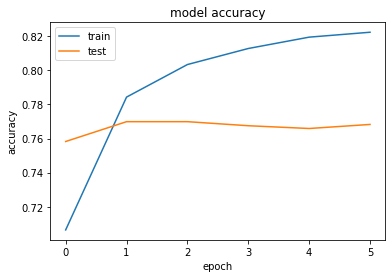

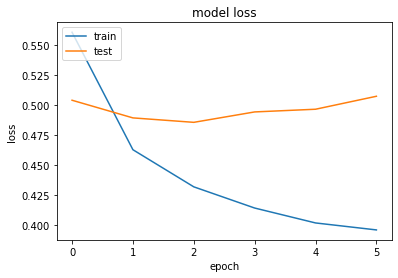

In [52]:
 import matplotlib. pyplot as plt
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
#CNN

In [54]:
from keras.layers import Activation,Conv1D,MaxPooling2D,Flatten
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [55]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test_tk, Y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 14s 434us/step - loss: 0.4812 - acc: 0.7676 - val_loss: 0.3821 - val_acc: 0.8290
Epoch 2/6
32000/32000 [==============================] - 16s 515us/step - loss: 0.3512 - acc: 0.8486 - val_loss: 0.3635 - val_acc: 0.8407
Epoch 3/6
32000/32000 [==============================] - 17s 529us/step - loss: 0.2987 - acc: 0.8774 - val_loss: 0.3432 - val_acc: 0.8518
Epoch 4/6
32000/32000 [==============================] - 19s 593us/step - loss: 0.2557 - acc: 0.9012 - val_loss: 0.3400 - val_acc: 0.8504
Epoch 5/6
32000/32000 [==============================] - 18s 577us/step - loss: 0.2149 - acc: 0.9213 - val_loss: 0.3513 - val_acc: 0.8475
Epoch 6/6
10000/10000 [==============================] - 2s 211us/step


In [56]:
pr = model.predict(X_test_tk)

In [57]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[4067,  894],
       [ 624, 4415]], dtype=int64)

In [58]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.3452936814546585
Test Accuracy: 0.8482000231742859


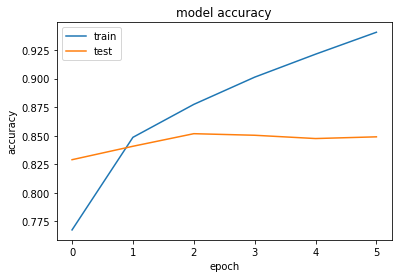

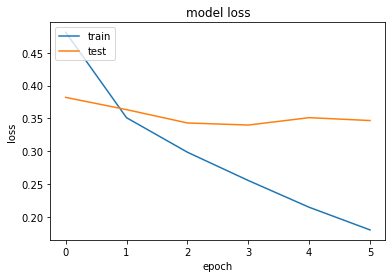

In [59]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [60]:
#LSTM

In [61]:
>>> from keras.layers import Embedding,LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [62]:
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 100)           9269600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,386,977
Trainable params: 117,377
Non-trainable params: 9,269,600
_________________________________________________________________
None


In [63]:
history = model.fit(X_train_tk, Y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test_tk, Y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 67s 2ms/step - loss: 0.4844 - acc: 0.7660 - val_loss: 0.4002 - val_acc: 0.8221
Epoch 2/6
32000/32000 [==============================] - 62s 2ms/step - loss: 0.3972 - acc: 0.8218 - val_loss: 0.3605 - val_acc: 0.8391
Epoch 3/6
32000/32000 [==============================] - 61s 2ms/step - loss: 0.3659 - acc: 0.8405 - val_loss: 0.3626 - val_acc: 0.8409
Epoch 4/6
32000/32000 [==============================] - 61s 2ms/step - loss: 0.3366 - acc: 0.8548 - val_loss: 0.3361 - val_acc: 0.8549
Epoch 5/6
32000/32000 [==============================] - 62s 2ms/step - loss: 0.3169 - acc: 0.8654 - val_loss: 0.3366 - val_acc: 0.8530
Epoch 6/6
10000/10000 [==============================] - 10s 994us/step


In [64]:
pr = model.predict(X_test_tk)

In [65]:
cnf_matrix = metrics.confusion_matrix(Y_test, pr.round())
cnf_matrix

array([[4405,  556],
       [ 828, 4211]], dtype=int64)

In [66]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.32966497783660886
Test Accuracy: 0.8615999817848206


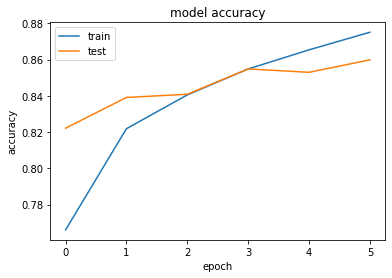

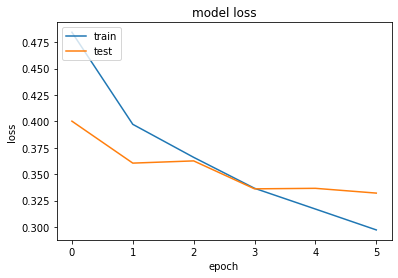

In [67]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2) , max_features= 100,strip_accents='unicode', norm='l2')

X_train_2 = vectorizer.fit_transform(X_train).todense()

X_test_2 = vectorizer.transform(X_test).todense()



In [70]:

model = Sequential()
model.add(Dense(100,input_shape= (100,)))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,201
Trainable params: 10,201
Non-trainable params: 0
_________________________________________________________________
None


history = model.fit(X_train_2, Y_train,  batch_size=128, epochs=6,verbose=1)